In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Make matplotlib plots bigger
plt.rcParams['figure.figsize'] = [15, 9]

We want to figure out the scale, rotation and translation between two images using phase correlation. We will transform an image with known parameters, and try to align it to the original. Because rotating and translating the image exposes the borders of the image, both images are cropped.

The Cat Lenna image is courtesy of [Captain Disillusion](https://www.youtube.com/@CaptainDisillusion).

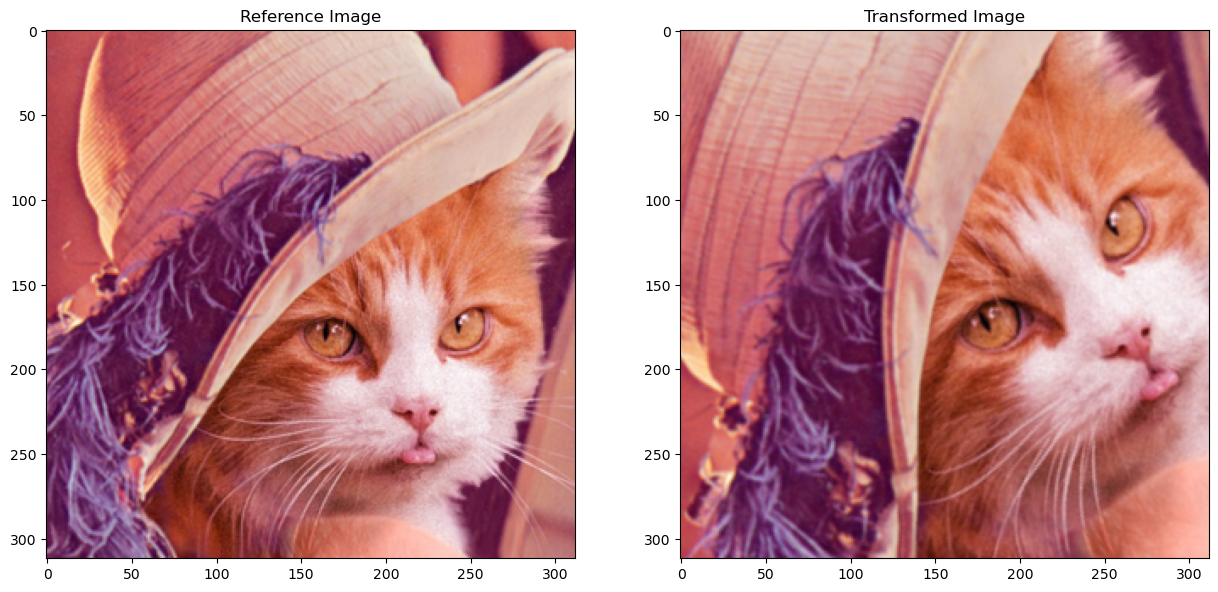

In [2]:
ref_image = plt.imread('images/Cat-Lenna.jpg')

#translate_y, translate_x = 15.4, -10.2
translate_y = translate_x = 0.0
scale = 1.2
rotation_degrees = 33.5

center = (ref_image.shape[1] // 2, ref_image.shape[0] // 2)

# Create rotation matrix around center with scaling
transform_matrix = cv2.getRotationMatrix2D(center, rotation_degrees, scale)

# Add translation to the matrix
transform_matrix[0, 2] += translate_x
transform_matrix[1, 2] += translate_y

transformed_image = cv2.warpAffine(
    ref_image,
    transform_matrix,
    dsize=(ref_image.shape[1], ref_image.shape[0]))

# Crop the images to remove borders that may appear due to transformation
crop_margin = 100

ref_image = ref_image[
    crop_margin:-crop_margin,
    crop_margin:-crop_margin]

transformed_image = transformed_image[
    crop_margin:-crop_margin,
    crop_margin:-crop_margin]

fig, ax = plt.subplots(1,2)
_ = ax[0].imshow(ref_image)
_ = ax[0].set_title('Reference Image')
_ = ax[1].imshow(transformed_image)
_ = ax[1].set_title('Transformed Image')

In [3]:
# We don't need colors, so we convert to grayscale
ref_image_gray = cv2.cvtColor(ref_image, cv2.COLOR_RGB2GRAY)
transformed_image_gray = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2GRAY)

We start by figuring out the rotation and scale. We can find the rotation and scale by putting both images through a Fast Fourier Transform, and then finding a translation between the results using phase correlation. One axis corresponds to rotation, and another to scale. We apply a bandpass filter to the image before converting to the frequency domain to suppress frequencies that could mess with the correlation.

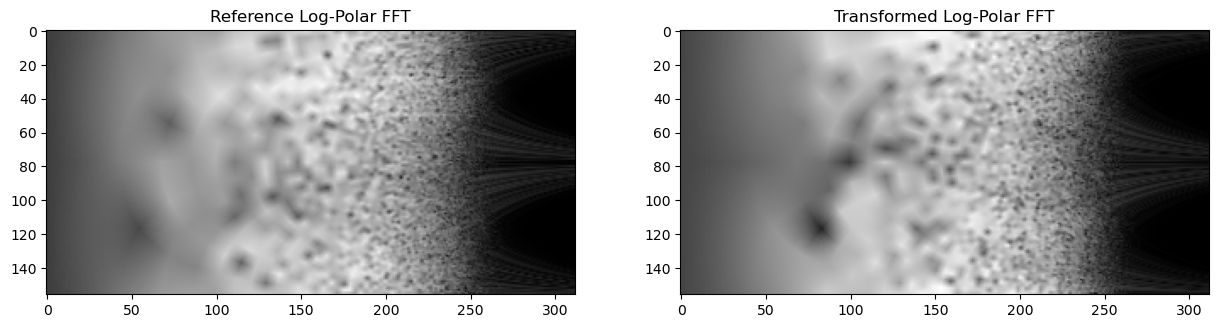

In [4]:
import skimage.filters

filtered_ref_image = skimage.filters.difference_of_gaussians(ref_image_gray, low_sigma=2, high_sigma=4)
filtered_transformed_image = skimage.filters.difference_of_gaussians(transformed_image_gray, low_sigma=2, high_sigma=4)

shape = filtered_ref_image.shape
shortest_side = np.min(shape)
radius = shortest_side // 2
def log_polar_fft(image, radius):
    fft = np.abs(np.fft.fftshift(np.fft.fft2(image)))
    # Amplitude spectra have very high values in the low frequencies, so we use logarithm to compress the range
    fft_mag_log = np.log(1.0 + fft)
    log_polar = cv2.warpPolar(
        src=fft_mag_log,
        dsize=(fft_mag_log.shape[1], fft_mag_log.shape[0]),
        center=(fft_mag_log.shape[1] // 2, fft_mag_log.shape[0] // 2),
        maxRadius=radius,
        flags=cv2.INTER_LINEAR | cv2.WARP_POLAR_LOG)
    return log_polar

ref_log_polar = log_polar_fft(filtered_ref_image, radius)
transformed_log_polar = log_polar_fft(filtered_transformed_image, radius)

# We only need half of the log-polar FFTs, as they are symmetric
ref_log_polar = ref_log_polar[:ref_log_polar.shape[0] // 2, :]
transformed_log_polar = transformed_log_polar[:transformed_log_polar.shape[0] // 2, :]

# Display the log-polar FFTs
fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(ref_log_polar, cmap='gray')
_ = ax[0].set_title('Reference Log-Polar FFT')
_ = ax[1].imshow(transformed_log_polar, cmap='gray')
_ = ax[1].set_title('Transformed Log-Polar FFT')

In [5]:
correlation_result = cv2.phaseCorrelate(ref_log_polar, transformed_log_polar)
print(f'Phase correlation result: {correlation_result}')

# We use 180 degrees instead of 360 degrees because we used half of the angular axis
print(f'OpenCV recovered rotation: {180.0 * -correlation_result[0][1] / ref_log_polar.shape[0]} degrees')
print(f'Expected rotation: {rotation_degrees} degrees')

# Recover scale from the correlation result
klog =  shortest_side / np.log(radius)
shift_scale = np.exp(-correlation_result[0][0] / klog)
print(f'OpenCV recovered scale: {shift_scale}')
print(f'Expected scale: {scale}')

Phase correlation result: ((-10.823473138503573, -29.146716228211247), 0.2703299744163377)
OpenCV recovered rotation: 33.63082641716682 degrees
Expected rotation: 33.5 degrees
OpenCV recovered scale: 1.1914637948753104
Expected scale: 1.2
